# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [3]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Include plots inline in the notebook
%matplotlib inline

#Read dataset
data = pd.read_csv("wholesale-customers.csv")
print("Dataset has {} rows, {} columns".format(*data.shape))
print(data.head())  # print the first 5 rows

FileNotFoundError: File b'wholesale-customers.csv' does not exist

##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer: Since PCA finds vectors that find maximum variance in the data and ICA finds vectors that are independant of one another, I would expect that the first dimension of PCA will result in a vector that explains high variance daily deliveries such as the feature "fresh", whereas ICA will likely return six vecotrs with all six features such that they are independant of one another.

###PCA

In [1]:
#Applying PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(data)

#Print components and variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(pca.components_)? (<ipython-input-1-75e522d99ef2>, line 7)

**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: For the first two dimensions, the variance is significantly higher than the additional four dimensions variance. For this dataset, if I were using PCA I would use two dimensions to capture roughly 0.86 of the variance. The inclusion of more dimensions doesn't result in a signficant impact to the explained variance in the data. 

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: The first component mostly consists of the feature Fresh, with Milk and Frozen also factoring in. The second component contains mainly Milk, Grocery, and Detergents/Paper.

Since most of the information (variance) is identified in the first two components, I would use this information to represent the data in two dimensions, described by the eigenvectors, as opposed to the 6 dimensions/features of the original dataset.

The dimensions represent the different types of customers, where in our case the majority of the variance is captured in the first two components which is useful to suggest that there are two distinct customer segments; high volume stores and low volume family run shops.

###ICA

In [3]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
from sklearn.preprocessing import scale

#centre_data = data
#centre_data -= centre_data.mean()

scaled_data = scale(data)

ica = FastICA(n_components=6, random_state = 42)
ica.fit(scaled_data)

# Print the independent components
print ica.components_

[[-0.0109083  -0.00108579  0.00730777  0.05405594 -0.00254136 -0.01675677]
 [ 0.00253788 -0.0123283   0.06912878  0.00142375 -0.01374853 -0.00544097]
 [-0.00490605 -0.00153897 -0.00562146 -0.002525    0.00238444  0.05092947]
 [-0.00336282  0.01863001  0.10899024 -0.00723244 -0.13338644 -0.0160228 ]
 [-0.05026646  0.00647203  0.00748246  0.00322414 -0.01147139  0.0027079 ]
 [-0.00193854 -0.07245463  0.05647623  0.0016736  -0.0171404   0.01695592]]


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: For ICA, the purpose is to separate multivariate signals in subcomponents that are statistically independant of one another. Since the vectors continually flipped order when running the ICA, a random state was set for consistency in output. 
The first component for this ICA analysis mainly consists of Frozen, with a bit of Fresh and Delicatessen. The next vector appears to be mostly comprised of Grocery, and some Milk and Detergents/Paper. The third component is principally Delicatessen. The fourth is mutually dominated by Grocery and Detergents/Paper. The fifth consists of Fresh, and some Detergents/Paper. The final vector is comprised of mainly Milk and Grocery, with a bit of Detergent/Paper and Delicatessen.

The components can be used as new a feature set that are all statistically independant of one another, which will work better with clustering and classification models. Each of these vectors in terms of this data set would represent a distinct customer segment for the delivery company.

##Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

###Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: The advantages of using K Means clustering is that it works well for large datasets and this model is much faster than hierarchical clustering. It is also one of the simplest algorithms for unsupervised learning, where a selected number of clusters' centroids are randomly placed and iteratively adjusted towards the clusters of points and for argument sake stabalize. The advantages to Gaussian Mixture Models is that it's one of the most statitsically mature methods for clustering and has similar goals to K Means, but also takles into account the structure of the data. It also allows for points to not be classified one way or another, but assigns probabilities to points inbetween the decision boundaries.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [4]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [36]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [37]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
gmm_2 = GMM(n_components = 2)
kmeans_2 = KMeans(n_clusters = 2)

gmm_3 = GMM(n_components = 3)
kmeans_3 = KMeans(n_clusters = 3)

gmm_6 = GMM(n_components = 6)

gmm_clusters2 = gmm_2.fit(reduced_data)
kmeans_clusters2 = kmeans_2.fit(reduced_data)
gmm_clusters3 = gmm_3.fit(reduced_data)
kmeans_clusters3 = kmeans_3.fit(reduced_data)
gmm_clusters6 = gmm_6.fit(reduced_data)

print gmm_clusters2
print kmeans_clusters2
print gmm_clusters3
print kmeans_clusters3
print gmm_clusters6

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)
KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)
KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=6, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


In [38]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z_gmm2 = gmm_clusters2.predict(np.c_[xx.ravel(), yy.ravel()])
Z_kmeans2 = kmeans_clusters2.predict(np.c_[xx.ravel(), yy.ravel()])
Z_gmm3 = gmm_clusters3.predict(np.c_[xx.ravel(), yy.ravel()])
Z_kmeans3 = kmeans_clusters3.predict(np.c_[xx.ravel(), yy.ravel()])
Z_gmm6 = gmm_clusters6.predict(np.c_[xx.ravel(), yy.ravel()])



In [39]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids_gmm2 = gmm_clusters2.means_
centroids_kmeans2 = kmeans_clusters2.cluster_centers_
centroids_gmm3 = gmm_clusters3.means_
centroids_kmeans3 = kmeans_clusters3.cluster_centers_
centroids_gmm6 = gmm_clusters6.means_

print centroids_gmm2
print centroids_kmeans2
print centroids_gmm3
print centroids_kmeans3
print centroids_gmm6

[[-10810.23008886   9858.15532401]
 [  3308.39301792  -3017.01739698]]
[[-24088.33276689   1218.17938291]
 [  4175.31101293   -211.15109304]]
[[  6987.95079141   4249.82914044]
 [   269.05318679  -6506.88683442]
 [-17879.18623839  10122.79246625]]
[[  4106.90273941  -3168.41202086]
 [-24220.71188261  -4364.45560022]
 [  1497.13461172  24998.27760147]]
[[  2917.75633744  -7172.67502341]
 [  3172.01367966  13259.54628747]
 [-31722.83442405  -6802.26852706]
 [-18416.8385771   45914.98214137]
 [  9533.08979559   2875.86777608]
 [ -5775.25608572  -2804.02019039]]


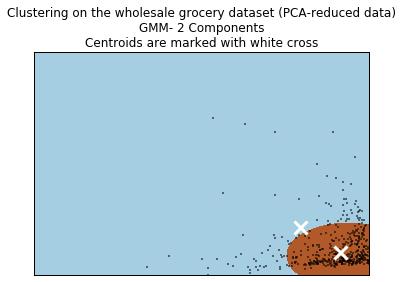

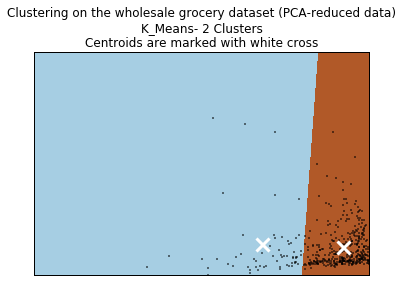

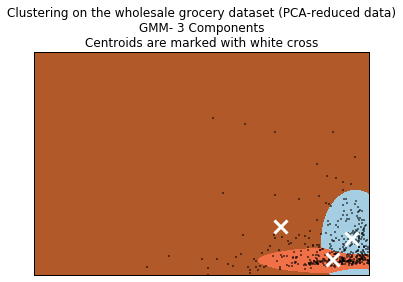

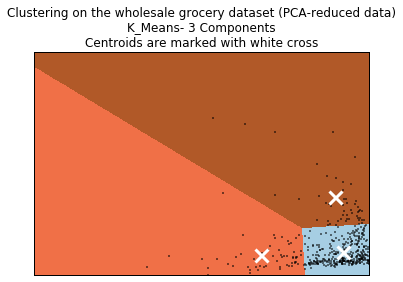

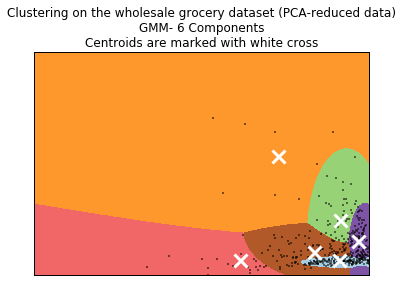

In [44]:
# Put the result into a color plot
Z_gmm2 = Z_gmm2.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z_gmm2, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids_gmm2[:, 0], centroids_gmm2[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'GMM- 2 Components\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Z_kmeans2 = Z_kmeans2.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z_kmeans2, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids_kmeans2[:, 0], centroids_kmeans2[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'K_Means- 2 Clusters\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Z_gmm3 = Z_gmm3.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z_gmm3, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids_gmm3[:, 0], centroids_gmm3[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'GMM- 3 Components\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Z_kmeans3 = Z_kmeans3.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z_kmeans3, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids_kmeans3[:, 0], centroids_kmeans3[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'K_Means- 3 Components\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Z_gmm6 = Z_gmm6.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z_gmm6, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids_gmm6[:, 0], centroids_gmm6[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'GMM- 6 Components\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: The central objects represent the average customer within each cluster. When using only 2 clusters, the object in the bottom right of the plot represents the average small family run shop customer with low variation between them. The other object which displays the average high volume customer covers a much larger portion of the plot suggesting high volume customers have large variation amongst themselves. Adding a third cluster divides the cluster observed in the bottom right of the plot into two, more narrow, clusters and they extend further into the space of the original high volume customers cluster form the two cluster model. As additional clusters are added the size of the clusters begin to shrink and the model appears to overfit the data with close groups of customers being divided into multiple clusters, where they were originally clustered together with models using smaller numbers of customers.

###Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: I feel using PCA, in association with GMM and two clusters gave the most insight into the data because it more appropriately clustered the significant chunk of smaller family shops grouped together in the bottom right corner of the plot than K Means or GMM with additional clusters. Two clusters was selected over three clusters because when adding the third cluster it divides the high volume customers into two serprate clusters based based on the specific items the customers are purchasing in high volume. This isn't what is being identified with this segmentation, we are purely trying to determine which customers purchase in large volumes (regardless of what the product is) vs which customer purchase in low volumes, so two clusters with GMM is the best model for this problem. With K Means, 2 clusters, it attributed the high variance customers in the upper right of the plot with the lower right customers, which didn't seem to fit as well. PCA further improved the model as it enabled dimensionality reduction for the clustering to identfiy the components with the highest variance.

**9)** How would you use that technique to help the company design new experiments?

Answer: Now that there are two distinct clusters (segments) of customers, they will be able to test any changes on the two different customers independantly to weigh the effects of the changes. This will eliminate the issue described in the beginning of the problem where the noise of the large volume customers eliminated the noise of the family run shops. If they had done this prior to their late night delivery change, they would have noticed a statistically significant change to the smaller customer segment and chose not to make the change for them, but only for their high volume custoemr segment. Further to this identification of high/low volume customers, they could also apply clustering to specific purchase types to observe which customers purchase more fresh/frozen foods and alter deliveries based on those results. Maybe switch from daily delivery to weekly for customer who purchase small volume of frozen food.

**10)** How would you use that data to help you predict future customer needs?

Answer: Not exactly sure of how to define "future customer needs", so I'll look at it both ways. The first understanding of future customer needs is completely new customers to deliver to and to determine how to handle them with this data. Now that two customer segments are known, based on the desired volume of a new customer it would be possible to categorize new customers and determine whether the customer should recieve deliveries at night or during the day from the above analysis.

The second way to intrpret "future customer needs" is for existing customers, what future needs can the data predict. This can be done through segmentation analysis of high vs low volume customers, or other divides on specific order types in an effort to predict segment/customer growth or profitability. This will then allow for the delivery company to focus theit efforts to specific customer segments.